In [65]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil
import random
import soundfile as sf

from tensorflow import keras
from keras import layers
from keras import models
import seaborn as sns

In [66]:
data_dir = './processed_dataset/'
processed_data_dir = './processed_dataset/'
commands = ['yes', 'no', 'up', 'down', 'left', 'right', 'stop', 'go']

batch_size = 64
epochs = 10

In [67]:
# train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
#     directory=data_dir,
#     batch_size=64,
#     validation_split=0.2,
#     seed=0,
#     output_sequence_length=16000,
#     subset='both')

# label_names = np.array(train_ds.class_names)
# print()
# print("label names:", label_names)

In [68]:
# # Define the split percentages
# train_percent = 0.8
# val_percent = 0.2

# try:
#     # Create directories for train, validation, and test
#     train_dir = os.path.join(data_in_use_dir, 'train')
#     val_dir = os.path.join(data_in_use_dir, 'val')

#     os.makedirs(train_dir, exist_ok=True)
#     os.makedirs(val_dir, exist_ok=True)

#     for command in commands:
#         command_path = os.path.join(processed_data_dir, command)
#         filenames = os.listdir(command_path)
#         random.shuffle(filenames)  # Shuffle the files

#         # Calculate split indices
#         num_files = len(filenames)
#         num_train = int(num_files * train_percent)
#         num_val = int(num_files * val_percent)

#         # Split the files into train, val, and test
#         train_files = filenames[:num_train]
#         val_files = filenames[num_train:num_train + num_val]

#         # Move the files to their respective directories
#         for filename in train_files:
#             src = os.path.join(command_path, filename)
#             dst = os.path.join(train_dir, command, filename) 
#             os.makedirs(os.path.dirname(dst), exist_ok=True)
#             shutil.copy(src, dst)

#         for filename in val_files:
#             src = os.path.join(command_path, filename)
#             dst = os.path.join(val_dir, command, filename)
#             os.makedirs(os.path.dirname(dst), exist_ok=True)
#             shutil.copy(src, dst)


#     print("Data split into train and validation")
# except:
#     print('Data already split')

In [69]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=processed_data_dir,
    batch_size=batch_size,
    validation_split=0.2,  # Adjust the validation split as needed
    seed=0,
    output_sequence_length=16000,  # Set the desired sequence length
    subset='both'  # Use 'validation' for the validation dataset
)

# Get the class names from the training dataset
label_names_train = np.array(train_ds.class_names)
print()
print("label names:", label_names_train)

Found 8000 files belonging to 8 classes.
Using 6400 files for training.
Using 1600 files for validation.

label names: ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']


In [70]:
print(label_names_train[[1,1,3,0]])
print(train_ds.element_spec)

['go' 'go' 'no' 'down']
(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))


In [71]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

In [72]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

# print out the number of samples in each set
print('Number of training samples: %d' % tf.data.experimental.cardinality(train_ds))
print('Number of validation samples: %d' % tf.data.experimental.cardinality(val_ds))
print('Number of test samples: %d' % tf.data.experimental.cardinality(test_ds))

Number of training samples: 100
Number of validation samples: 12
Number of test samples: 13


In [73]:
for audio, labels in train_ds.take(1):  
  print(audio.shape)
  print(labels.shape)

(64, 16000)
(64,)


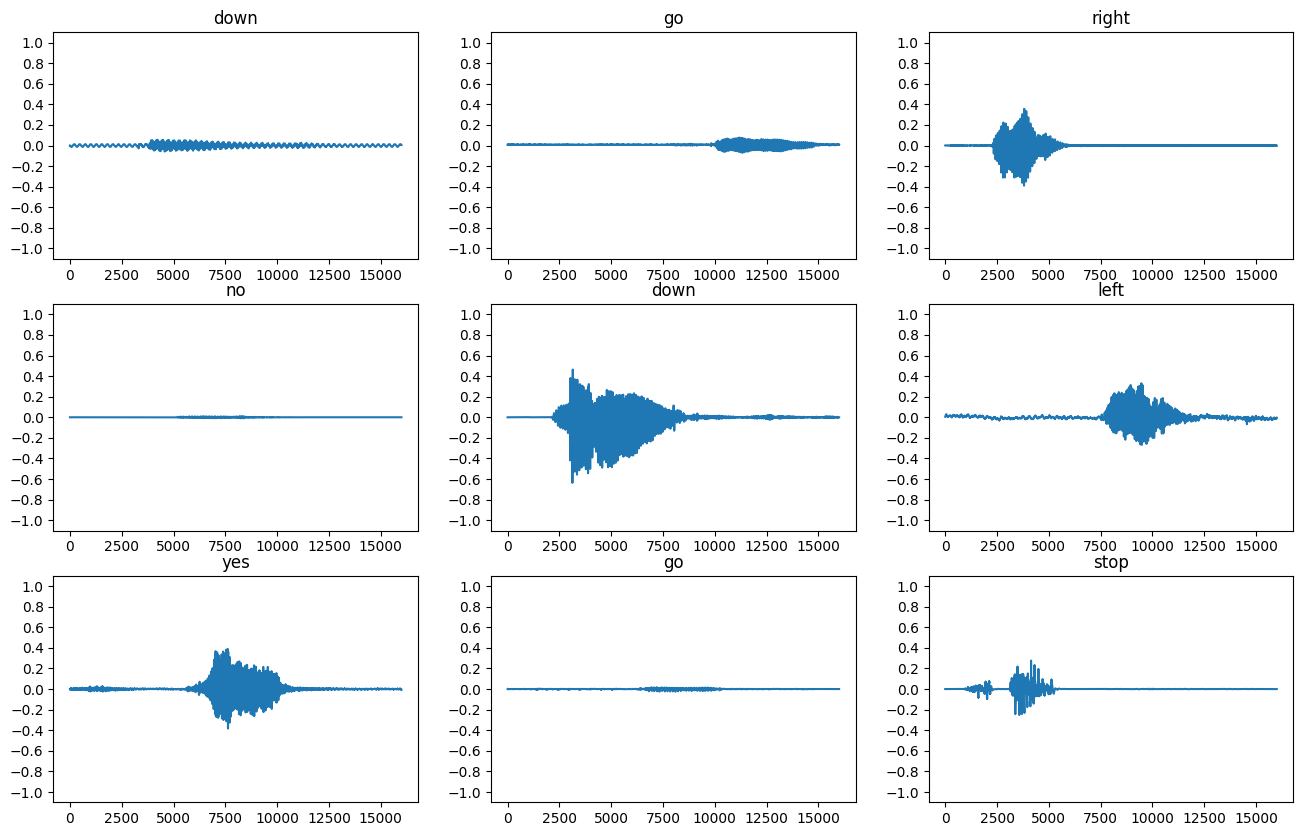

In [74]:
plt.figure(figsize=(16, 10))
rows = 3
cols = 3
n = rows * cols
for i in range(n):
  plt.subplot(rows, cols, i+1)
  audio_signal = audio[i]
  plt.plot(audio_signal)
  name = label_names_train[labels[i]]
  plt.title(str(name))
  plt.yticks(np.arange(-1.2, 1.2, 0.2))
  plt.ylim([-1.1, 1.1])

In [75]:
def get_spectrogram(waveform):
    spectrogram = tf.signal.stft(waveform, frame_length=255, frame_step=128)
    spectrogram = tf.abs(spectrogram)
    spectrogram = spectrogram[..., tf.newaxis]
    return spectrogram

def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
    log_spec = np.log(spectrogram.T + np.finfo(float).eps)
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
    Y = range(height)
    ax.pcolormesh(X, Y, log_spec)

In [76]:
for i in range(3):
  label = label_names_train[labels[i]]
  waveform = audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)

Label: down
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Label: go
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Label: right
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)


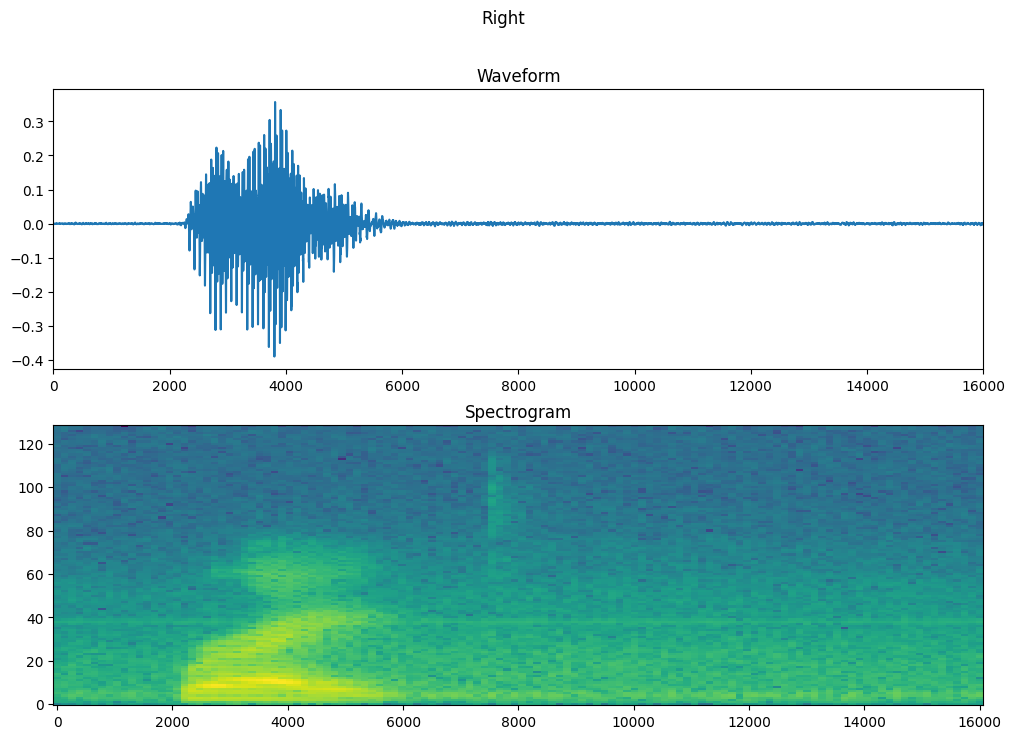

In [77]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

In [78]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [79]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

In [80]:
for spectrograms, spect_labels in train_spectrogram_ds.take(1):
  break

In [81]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

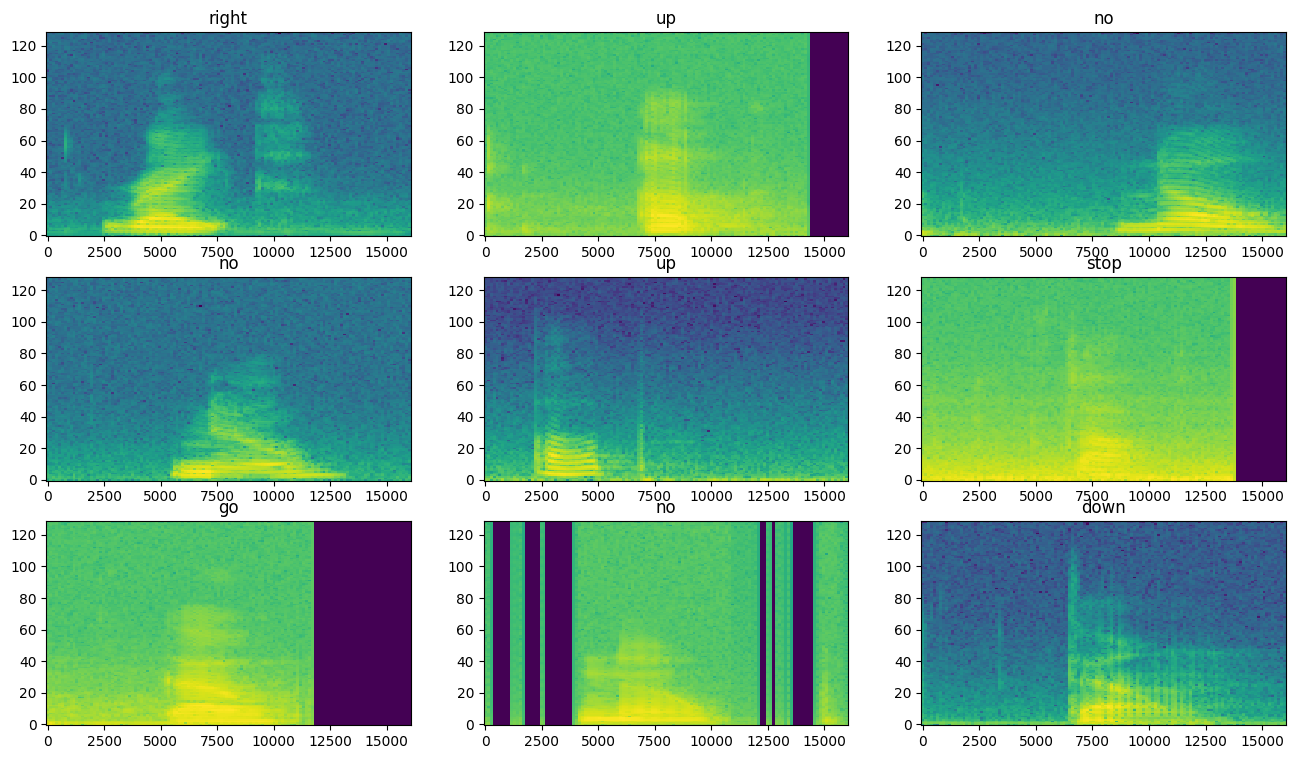

In [82]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(spectrograms[i].numpy(), ax)
    ax.set_title(label_names_train[spect_labels[i].numpy()])

plt.show()

In [83]:
input_shape = spectrograms.shape[1:]
print('Input shape:', input_shape)

norm_layer = layers.Normalization()
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Resizing(32, 64),
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(8),
])

model.summary()

Input shape: (124, 129, 1)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_1 (Resizing)       (None, 32, 64, 1)         0         
                                                                 
 normalization_1 (Normaliza  (None, 32, 64, 1)         3         
 tion)                                                           
                                                                 
 conv2d_2 (Conv2D)           (None, 30, 62, 32)        320       
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 60, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 30, 64)        0         
 g2D)                                                            
                                                                 
 dropout_2 (Dropout)       

In [84]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [85]:
EPOCHS = 20
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/20


100/100 [==============================] - 18s 170ms/step - loss: 1.8278 - accuracy: 0.3170 - val_loss: 1.3203 - val_accuracy: 0.5846
Epoch 2/20
100/100 [==============================] - 15s 145ms/step - loss: 1.1737 - accuracy: 0.6116 - val_loss: 0.8258 - val_accuracy: 0.7500
Epoch 3/20
100/100 [==============================] - 14s 141ms/step - loss: 0.8380 - accuracy: 0.7278 - val_loss: 0.6860 - val_accuracy: 0.8021
Epoch 4/20
100/100 [==============================] - 14s 141ms/step - loss: 0.6757 - accuracy: 0.7741 - val_loss: 0.5817 - val_accuracy: 0.8216
Epoch 5/20
100/100 [==============================] - 14s 143ms/step - loss: 0.5661 - accuracy: 0.8075 - val_loss: 0.5412 - val_accuracy: 0.8451
Epoch 6/20
100/100 [==============================] - 14s 140ms/step - loss: 0.5011 - accuracy: 0.8330 - val_loss: 0.4773 - val_accuracy: 0.8529
Epoch 7/20
100/100 [==============================] - 14s 140ms/step - loss: 0.4438 - accuracy: 0.8481 - val_loss: 0.4729 - val_accuracy: 0.8

Text(0, 0.5, 'Accuracy [%]')

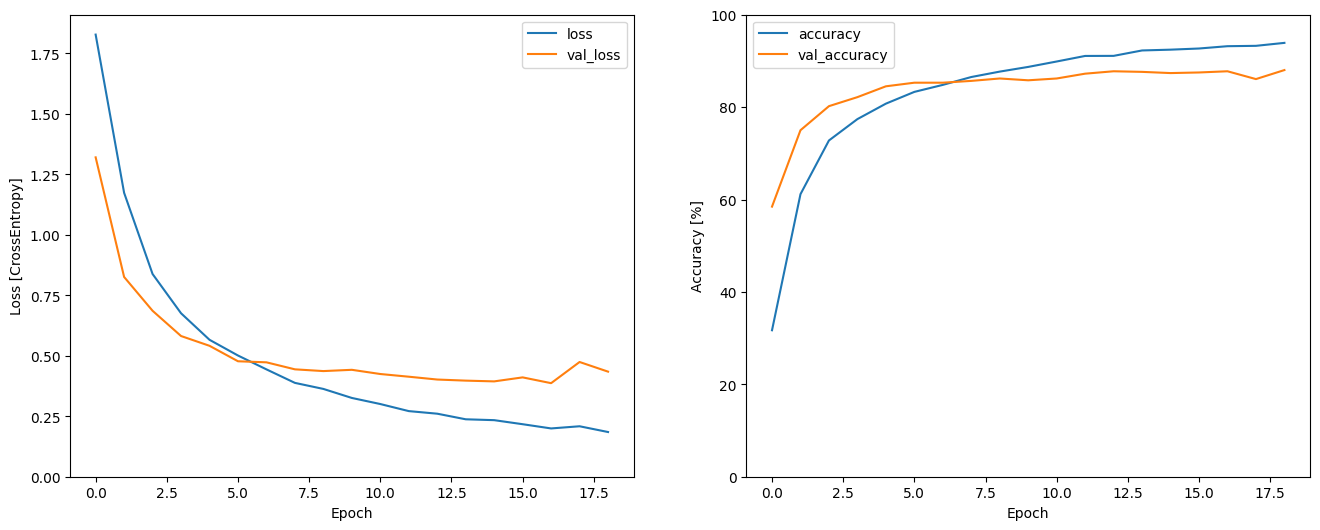

In [86]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

In [87]:
model.evaluate(test_spectrogram_ds, return_dict=True)

13/13 [==============================] - 1s 60ms/step - loss: 0.5992 - accuracy: 0.8510


{'loss': 0.5992216467857361, 'accuracy': 0.8509615659713745}

In [88]:
y_pred = model.predict(test_spectrogram_ds)
y_pred = tf.argmax(y_pred, axis=1)
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

13/13 [==============================] - 1s 35ms/step


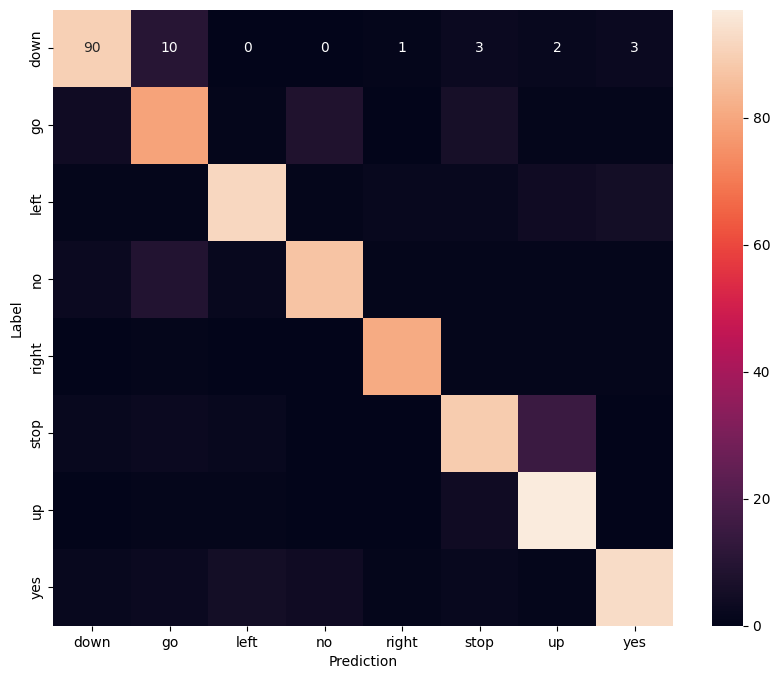

In [89]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names_train,
            yticklabels=label_names_train,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

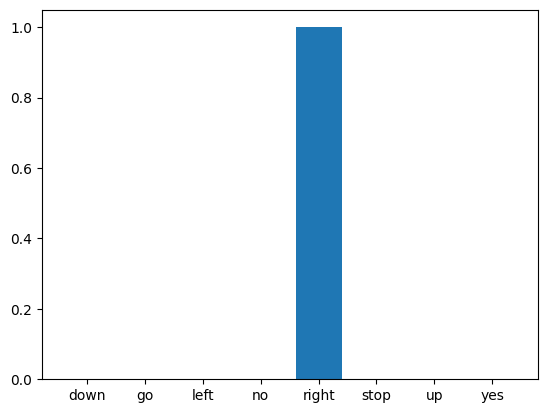

In [90]:
# input x as a wav in test_ds
x = "./processed_dataset/right/01d22d03_nohash_0.wav"
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
x = tf.squeeze(x, axis=-1)
waveform = x

x = get_spectrogram(x)
x = x[tf.newaxis,...]

prediction = model(x)
x_labels = ['down', 'go', 'left', 'no', 'right', 'stop', 'up', 'yes']
plt.bar(x_labels, tf.nn.softmax(prediction[0]))
plt.show()



In [91]:
class ExportModel(tf.Module):
  def __init__(self, model):
    self.model = model

    # Accept either a string-filename or a batch of waveforms.
    # You could add additional signatures for a single wave, or a ragged-batch. 
    self.__call__.get_concrete_function(
        x=tf.TensorSpec(shape=(), dtype=tf.string))


    self.__call__.get_concrete_function(
        x=tf.TensorSpec(shape=[None, 16000], dtype=tf.float32))

  @tf.function
  def __call__(self, x):
    # If they pass a string, load the file and decode it. 
    if x.dtype == tf.string:
      x = tf.io.read_file(x)
      x, _ = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
      x = tf.squeeze(x, axis=-1)
      x = x[tf.newaxis, :]

    x = get_spectrogram(x)  
    result = self.model(x, training=False)

    class_ids = tf.argmax(result, axis=-1)
    class_names = tf.gather(label_names_train, class_ids)
    return {'predictions':result,
            'class_ids': class_ids,
            'class_names': class_names}

In [92]:
export = ExportModel(model)

In [93]:
tf.saved_model.save(export, "saved")

INFO:tensorflow:Assets written to: saved\assets


INFO:tensorflow:Assets written to: saved\assets


In [94]:
export(tf.constant(str("./processed_dataset/right/01d22d03_nohash_0.wav")))

{'predictions': <tf.Tensor: shape=(1, 8), dtype=float32, numpy=
 array([[-14.437488  ,  -6.122592  ,   9.905004  , -11.519796  ,
          20.402498  ,  -8.775332  ,  -0.18811028,  -4.945061  ]],
       dtype=float32)>,
 'class_ids': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([4], dtype=int64)>,
 'class_names': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'right'], dtype=object)>}

In [95]:
model = tf.saved_model.load('saved')

In [99]:
from pydub import AudioSegment

audio_path = "./right_nvt.wav"
audio = AudioSegment.from_file(audio_path)

audio = audio.set_channels(1)
audio = audio.set_frame_rate(16000)

output_path = "./mono_16000.wav"
audio.export(output_path, format="wav")

print(f"Mono audio with 16000 Hz sample rate saved to {output_path}")

Mono audio with 16000 Hz sample rate saved to ./mono_16000.wav


In [100]:
import soundfile as sf

audio_path = "./mono_16000.wav"
audio, sample_rate = sf.read(audio_path, dtype='float32')

print(f"Audio type: {type(audio)}")
print(f"Sample rate: {sample_rate}")

Audio type: <class 'numpy.ndarray'>
Sample rate: 16000


In [101]:
export(tf.constant(str("./mono_16000.wav")))

{'predictions': <tf.Tensor: shape=(1, 8), dtype=float32, numpy=
 array([[-8.150516  , -8.18918   ,  5.7098403 , -6.92386   , 14.681789  ,
         -9.936898  , -2.495011  , -0.86019754]], dtype=float32)>,
 'class_ids': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([4], dtype=int64)>,
 'class_names': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'right'], dtype=object)>}